In [1]:
import numpy as np
import pandas as pd
import time, sys, json, os, io, cv2, base64
from io import BytesIO
from subprocess import check_output
from pprint import pprint as pp
import pymongo
from pymongo import MongoClient
import hashlib
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
from imageio import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from random import randint
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from keras.preprocessing.image import load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, BatchNormalization
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.backend.tensorflow_backend import set_session
from keras.losses import binary_crossentropy
import tensorflow as tf

from tqdm import tqdm_notebook

Using TensorFlow backend.


In [2]:
img_size_ori = 101
img_size_target = 128

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]
    
# Source https://www.kaggle.com/bguberfain/unet-with-depth
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [3]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

In [4]:
# model = load_model("../unet_resnet/model-unet-resnet.h5", custom_objects={'mean_iou':mean_iou})
model = load_model("../unet_resnet/model-unet-resnet.h5", custom_objects={'mean_iou':mean_iou, 'bce_dice_loss':bce_dice_loss})

In [5]:
train_df = pd.read_csv("../data/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("../data/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

In [6]:
# for later test normalization
depth_mean = np.mean(train_df['z'].values)
depth_std = np.std(train_df['z'].values)
train_d = (train_df.z.values-depth_mean)/depth_std
test_d = (test_df.z.values-depth_mean)/depth_std

In [7]:
img_size_ori = 101
img_size_target = 128

def read_resize_img(path, scale, clahe=False, mask=False):
    img_np = np.array(load_img(path, grayscale=True))
    if clahe:
        img_np = img_np.astype(dtype=np.uint8)
        clahe = cv2.createCLAHE(clipLimit=40.0, tileGridSize=(8,8))
        img_clahe = clahe.apply(img_np) if clahe else img_np
    else:
        img_clahe = img_np
    img_scale = img_clahe/scale
    img_resize = resize(img_scale,(img_size_target,img_size_target), mode='constant', preserve_range=True) 
    if mask:
        img_resize[img_resize>0] = 1
    return img_resize

In [8]:
# x_train = np.array([ read_resize_img("../data/train/{}.png".format(idx), 255, clahe=False) for idx in tqdm_notebook(train_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

In [9]:
x_test = np.array([ read_resize_img("../data/test/{}.png".format(idx), 255, clahe=False) for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

In [10]:
# preds_test = model.predict({'img': x_test, 'feat': test_d}, batch_size=32, verbose=1)
preds_test = model.predict(x_test, batch_size=32, verbose=1)

18000/18000 [==============================] - 50s 3ms/step


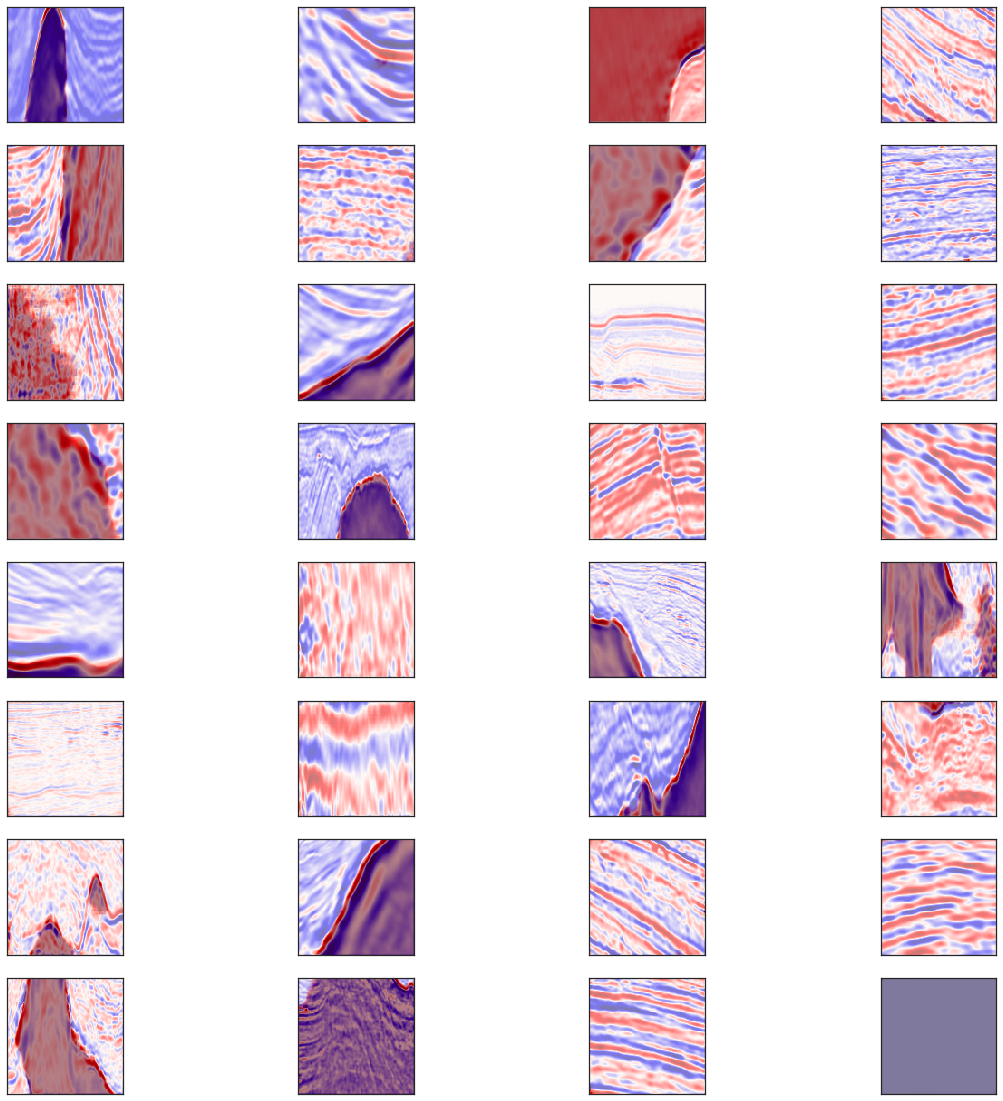

In [11]:
base_idx = 16000
max_images = 32
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
row = 0; col = 0;
for i in range(base_idx,base_idx+int(max_images)):
    img = x_test[i].squeeze()
    mask = preds_test[i].squeeze()
    
    ax = axs[row, col];
    ax.imshow(img, cmap="seismic")
    ax.imshow(mask, alpha=0.5, cmap="Reds"); col+=1;
    ax.set_yticklabels([]); ax.set_xticklabels([]);
    
    if col >= grid_width:
        col=0; row+=1;


In [12]:
threshold_best=0.15789473684210525
pred_dict = {idx: RLenc(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission_BN_res_less_dropout.csv')